few shot examples

# LLM - Large Language Models avagy Nagy Nyelvi Modellek

## 1. Mik azok a (Nagy) Nyelvi Modellek?

Egy LM (Language Model) a bemenet alapján előrejelzi a következő szót.

Input: Ma szépen süt a

Output: nap

Attól függően, hogy milyen volt a tanításhoz használt __corpus__ a következő szó előrejelzés jelentősen eltérhet. A következő szó előrejelzése valószínűség alapján történik: melyik a legvalószínűbb következő szó. Ez a valószínűség nyilván attól fogg függni, hogy mit látott korábban a modell, mit tanult meg. Ezért fontos a __corpus__.

Mivel csak valószínűségeknek van szerepe, ezért lehet, hogy a legvalószínűbb predikció nincs kapcsolatban a valósággal.

Ezek ugyan olyan neurális hálózatok, mint amilyeneket korábban láttunk, a különbség azokhoz képest (mint ahogy az már sejthető is) leginkább a tanításuk módjában rejlik. A tanításuk általában több lépésben történik:
- pre-training: a corpus alapján megtanítják a modellnek a következő token előrejelzését
- supervised fine tuning:
  - ez előtanított modellnek megtanítják, hogyan kövessen utasításokat, ezáltal könnyebbé teszik a használatát
  - egy olyan előre összeállított adathalmaz, amiben megvan a user által feltett kérdés és megvan az elvárt válasz
- reinforcement learning with human feedback:
  -  finomhangolják a modellt, hogy jobban kövesse az emberi értékrendet, emberi gondolkodást

A nagy nyelvi modellek (LLM) felépítése több rétegű neurális hálózatokból áll. Ezek a rétegek közé tartoznak a embedding rétegek, a recurrent rétegek, a feedforward rétegek és a attention rétegek.

A beágyazó (embedding) réteg a bemeneti szöveg minden egyes szavát nagydimenziós vektorreprezentációvá alakítja. Ez a reprezentáció szemantikai és szintaktikai információkat rögzít a szóról, ami segít a modellnek megérteni a kontextust.

A feedforward rétegek nemlineáris transzformációkat alkalmaznak a bemeneti beágyazásokra. Ez segít a modellnek magasabb szintű absztrakciókat tanulni a bemeneti szövegből.

A rekurrens rétegek sorban értelmezik a bemeneti szövegből származó információkat. Fenntartanak egy rejtett állapotot, amely minden egyes következő szónál frissül, így a modell képes megragadni a mondatban lévő szavak közötti függőségeket.

A figyelem (attention) mechanizmus lehetővé teszi, hogy a modell szelektíven a bemeneti szöveg különböző részeire összpontosítson. Ez segít a modellnek a bemeneti szöveg leglényegesebb részeire figyelni, és pontosabb előrejelzéseket generálni.

## 2. LLM használata Azure OpenAI-val

- **Kérés/válasz minta**: Hasonló a REST API-khoz
- **Üzenetek**: Beszélgetési kontextus (system, user, assistant szerepek)
- **Model paraméter**: Meghatározza, melyik LLM-et használjuk
- **Temperature és egyéb paraméterek**: Viselkedés szabályozása

In [25]:
import os
from openai import AzureOpenAI

endpoint = os.getenv("AZURE_API_BASE")
model_name = os.getenv("AZURE_API_MODEL")
deployment = os.getenv("AZURE_API_MODEL")

subscription_key = os.getenv("AZURE_API_KEY")
api_version = os.getenv("AZURE_API_VERSION")

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=subscription_key,
)

In [26]:
response = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a professor of data science and artificial intelligence, and you need to answer questions from your students. You need to be very precise with your answers, but at the same time try to be short.",
        },
        {
            "role": "user",
            "content": "What is the half of the meaning of life?",
        }
    ],
    max_completion_tokens=800,
    temperature=1.0,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0,
    model=deployment
)

print(response.choices[0].message.content)

If we consider the "meaning of life" as 42 (from Douglas Adams' *The Hitchhiker's Guide to the Galaxy*), then half of it would be 21. However, philosophically, the "meaning of life" varies widely by perspective and isn't a numerical value.


In [27]:
import dotenv
import dspy

dotenv.load_dotenv()
lm = dspy.LM("azure/"+os.getenv("AZURE_API_MODEL"), temperature=0.1, max_tokens=768)
dspy.configure(lm=lm)

In [28]:
lm("Write a haiku about dspy, but be technical?")[0].replace('\n', '')

'Data streams converge,  Python scripts parse, transform, flow—  dspy crafts insights.'

## 3. Tokenek

**Mik azok a Tokenek?**

- A szöveg **"tokenekre"** bontva (gyakran részszavak, nem teljes szavak)
- Az LLM-ek a tokeneket számokként dolgozzák fel (nem szövegként)
- A tokenizáció hatással van a **költségre**, **kontextus méretre** és **viselkedésre**
  - általában tokenek alapján számláznak

In [47]:
import tiktoken
enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"
enc.encode("hello world"), enc.encode("hello world again")

([24912, 2375], [24912, 2375, 2418])

In [48]:
enc = tiktoken.get_encoding("cl100k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"
enc.encode("hello world"), enc.encode("hello world again")

([15339, 1917], [15339, 1917, 1578])

In [45]:
import tiktoken

texts = [
    "Szia, világ! Hogy vagy ma? 😊",
    "A gyors barna róka átugrik a lusta kutya felett.",
    "def fibonacci(n): return n if n <= 1 else fibonacci(n-1) + fibonacci(n-2)",
    "Bonjour! Comment allez-vous?",
    "こんにちは世界"
]

encoding = tiktoken.encoding_for_model("gpt-4o")

for text in texts:
    tokens = encoding.encode(text)
    print(f"Eredeti szöveg: {text}")
    print(f"Tokenek száma: {len(tokens)}")
    print(f"Tokenek: {tokens}")
    
    print("Egyedi tokenek:")
    for i, token in enumerate(tokens[:10]):  # Első 10 token megjelenítése
        decoded = encoding.decode([token])
        print(f"  Token {i}: {token} → '{decoded}'")
    if len(tokens) > 10:
        print(f"  ... és még {len(tokens) - 10} token")

Eredeti szöveg: Szia, világ! Hogy vagy ma? 😊
Tokenek száma: 11
Tokenek: [50, 46452, 11, 137997, 0, 487, 11620, 41399, 831, 30, 156273]
Egyedi tokenek:
  Token 0: 50 → 'S'
  Token 1: 46452 → 'zia'
  Token 2: 11 → ','
  Token 3: 137997 → ' világ'
  Token 4: 0 → '!'
  Token 5: 487 → ' H'
  Token 6: 11620 → 'ogy'
  Token 7: 41399 → ' vagy'
  Token 8: 831 → ' ma'
  Token 9: 30 → '?'
  ... és még 1 token
Eredeti szöveg: A gyors barna róka átugrik a lusta kutya felett.
Tokenek száma: 16
Tokenek: [32, 188566, 138454, 31335, 1854, 88397, 846, 26530, 261, 305, 27623, 8910, 2090, 1193, 41208, 13]
Egyedi tokenek:
  Token 0: 32 → 'A'
  Token 1: 188566 → ' gyors'
  Token 2: 138454 → ' barna'
  Token 3: 31335 → ' ró'
  Token 4: 1854 → 'ka'
  Token 5: 88397 → ' át'
  Token 6: 846 → 'ug'
  Token 7: 26530 → 'rik'
  Token 8: 261 → ' a'
  Token 9: 305 → ' l'
  ... és még 6 token
Eredeti szöveg: def fibonacci(n): return n if n <= 1 else fibonacci(n-1) + fibonacci(n-2)
Tokenek száma: 23
Tokenek: [1314, 1659

OpenAI Tokenizer Web: https://platform.openai.com/tokenizer

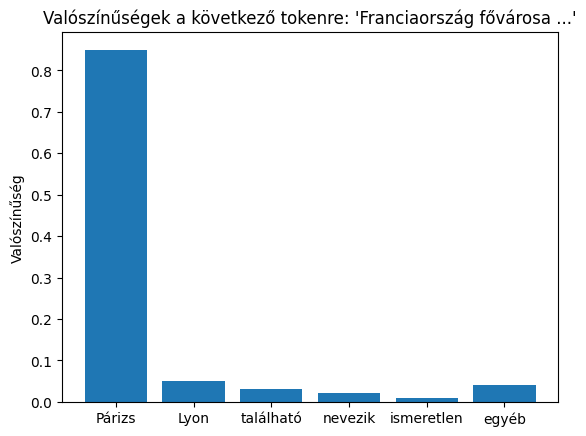

In [51]:
import matplotlib.pyplot as plt
kov_token_probak = {"Párizs": 0.85, "Lyon": 0.05, "található": 0.03, "nevezik": 0.02, "ismeretlen": 0.01, "egyéb": 0.04}
plt.bar(kov_token_probak.keys(), kov_token_probak.values())
plt.title("Valószínűségek a következő tokenre: 'Franciaország fővárosa ...'")
plt.ylabel("Valószínűség")
plt.show()

In [62]:
import time

def teszt_temperature(client):
    prompt = "Irj egy vidám történetet egy kisegérről. Maximum 3 mondat legyen."
    for temp in [0.1, 0.7, 1.2]:
        time.sleep(0.2)
        print(f"\n--- Hőmérséklet {temp} ---")
        try:
            response = client.chat.completions.create(
                model=deployment,
                messages=[{"role": "user", "content": prompt}],
                temperature=temp,
                max_tokens=100
            )
            print(response.choices[0].message.content)
        except Exception as e:
            print(f"API hiba: {e}")

In [63]:
teszt_temperature(client)


--- Hőmérséklet 0.1 ---
Egy kis egér, akit Mici-nek hívtak, minden reggel táncolva szaladt ki a lyukából, hogy megkeresse a legédesebb sajtdarabkát. Egy nap azonban egy hatalmas sajttorta közepén találta magát, amit a gazdi készített a születésnapjára! Mici boldogan osztozott a tortán a családdal, és azóta ő lett

--- Hőmérséklet 0.7 ---
Egy kis egér, akit Miki-nek hívtak, mindig megnevettette a barátait a vidám táncával. Egyszer véletlenül belezuhant egy sajttortába, és onnantól kezdve minden nap egy kis sajtos kaland várta. Így Miki lett a legboldogabb egér a világon, aki mindig talált valami mókás meglepetést!

--- Hőmérséklet 1.2 ---
Egy aprócska kisegér, aki imádott táncolni, egyszer véletlenül egy csokitorta tetején landolt a nagyi konyhájában. Miközben vidáman forgott és pattogott a csokis édességen, a kutya is csatlakozott hozzá egy barátságos kutya-macska-móka partijára. Így lett a kisegérből a terület leg


### A temperature működése

- Alapfolyamat: Az LLM először kiszámítja minden lehetséges token "nyers pontszámát" (logits)
- Temperature alkalmazása: Ezeket a pontszámokat elosztja a temperature értékével
- Softmax: Az eredményen softmax függvényt alkalmaz, ami valószínűség-eloszlást ad


Temperature = 0.1 (alacsony):

- A legnagyobb pontszámú tokenek még nagyobb valószínűséget kapnak
- Determinisztikusabb, kiszámíthatóbb válaszok


Temperature = 1.0 (semleges):

- Az eredeti valószínűség-eloszlás változatlan


Temperature = 2.0 (magas):

- A valószínűségek "kiegyenlítődnek"
- Kevésbé valószínű tokenek is nagyobb esélyt kapnak



**Példa**

Ha az eredeti logitok: [4.0, 3.0, 2.0] token-ekre:

- Temperature 0.5-nél: ~[0.85, 0.12, 0.03] valószínűségek
- Temperature 1.0-nél: ~[0.67, 0.24, 0.09] valószínűségek
- Temperature 2.0-nél: ~[0.46, 0.31, 0.23] valószínűségek

Tehát a temperature megváltoztatja a következő token kiválasztásának valószínűség-eloszlását.

## Prompt Engineering

Ezt minden egyes modell családnál érdemes figyelembe venni: https://cookbook.openai.com/examples/gpt4-1_prompting_guide

In [ ]:
promtok = [
"Írj kódot",
"Írj egy Python függvényt, amely kiszámolja egy szám faktoriálisát",
"Írj egy Python függvényt, amely: \
 1. Pozitív egész szám faktoriálisát számolja \
 2. Hibakezelést tartalmaz \
 3. Dokumentált példákkal \
 4. Rekurzív"
]
for i, prompt in enumerate(promtok):
    print('='*80)
    print('\n', prompt)
    print('-'*80)
    time.sleep(0.2)
    try:
        response = client.chat.completions.create(
            model=deployment,
            messages=[{"role": "user", "content": prompt}],
            temperature=1.0,
            max_tokens=500
        )
        print(response.choices[0].message.content, '\n')
    except Exception as e:
        print(f"API hiba: {e}")


 Írj kódot
Persze! Milyen típusú kódot szeretnél? Például Python, JavaScript, C++, vagy valami más? Milyen feladatot szeretnél megoldani? 


 Írj egy Python függvényt, amely kiszámolja egy szám faktoriálisát
Természetesen! Íme egy egyszerű Python függvény, amely kiszámolja egy szám faktoriálisát rekurzívan:

```python
def faktorialis(n):
    if n < 0:
        raise ValueError("A faktoriális csak nem negatív egész számokra értelmezett.")
    elif n == 0 or n == 1:
        return 1
    else:
        return n * faktorialis(n - 1)

# Példa használat:
print(faktorialis(5))  # Eredmény: 120
```

Ha iteratív megoldás érdekel, azt is meg tudom mutatni! 


 Írj egy Python függvényt, amely:  1. Pozitív egész szám faktoriálisát számolja  2. Hibakezelést tartalmaz  3. Dokumentált példákkal  4. Rekurzív
Íme egy Python függvény, amely rekurzívan számolja egy pozitív egész szám faktoriálisát, hibakezeléssel és dokumentációval, példákkal együtt:

```python
def factorial(n):
    """
    Számolja a meg

### One, Few, Many-shot learning

A few-shot learning az egyik leghatékonyabb prompt engineering technika, ami arra épül, hogy az LLM-ek kiválóan tudnak tanulni példákból a kontextusban. Ahelyett, hogy csak leírnád mit szeretnél, mutatsz néhány konkrét példát a kívánt formátumra/stílusra, az LLM ezt a mintát fogja követni.

- One-shot: 1 példa
- Few-shot: 2-5 példa (általában 3 az optimális)
- Many-shot: 5+ példa

In [76]:
def create_few_shot_prompt(task_description, examples, new_input):
    prompt = f"{task_description}\n\nPéldák:\n"
    
    for example in examples:
        prompt += f"Input: {example['input']}\n"
        prompt += f"Output: {example['output']}\n\n"
    
    prompt += f"Most ezt dolgozd fel:\nInput: {new_input}\nOutput:"
    return prompt

examples = [
    {"input": "def factorial(n):", "output": "Faktoriális számítás függvény"},
    {"input": "class Car:", "output": "Autó osztály definíció"},
    {"input": "import pandas", "output": "Pandas könyvtár importálás"}
]

prompt = create_few_shot_prompt(
    "Írj rövid, magyar nyelvű leírást Python kód részletekről",
    examples,
    "for i in range(10):"
)

In [80]:
print(prompt)

Írj rövid, magyar nyelvű leírást Python kód részletekről

Példák:
Input: def factorial(n):
Output: Faktoriális számítás függvény

Input: class Car:
Output: Autó osztály definíció

Input: import pandas
Output: Pandas könyvtár importálás

Most ezt dolgozd fel:
Input: for i in range(10):
Output:


In [77]:
lm(prompt)

['Ciklus, amely 0-tól 9-ig iterál.']

In [78]:
response = client.chat.completions.create(
            model=deployment,
            messages=[{"role": "user", "content": prompt}],
            temperature=1.0,
            max_tokens=500
        )
print(response.choices[0].message.content, '\n')

Ciklus, amely 0-tól 9-ig iterál 



## Chain of Tought (CoT)

A Chain of Thought (CoT) egy prompt engineering technika, ami arra tanítja az LLM-et, hogy lépésről lépésre, strukturáltan gondolkodjon a válasz megadása előtt.

Gyakorlatilag megkéred, hogy mutassa meg a gondolkodási folyamatát az LLM - minden lépést, ami a megoldáshoz vezet.

A Chain of Thought lényegében arra tanítja az LLM-et, hogy "hangosan gondolkodjon" - ahogy mi emberek is gyakran jobban oldunk meg problémákat, ha végigbeszéljük őket.

In [84]:
print(lm("Mennyi az esélye hogy két dobókockát feldobva két hatost dobok?")[0])

Két dobókockával dobva az esély, hogy mindkettőn hatost dobj:

- Egy dobókockán a hatos dobás valószínűsége: \(\frac{1}{6}\).
- Két dobókockán a két hatos dobás valószínűsége: \(\frac{1}{6} \times \frac{1}{6} = \frac{1}{36}\).

Tehát az esélye, hogy két dobókockával két hatost dobj, \(\frac{1}{36}\), vagy kb. 2,78%.


In [85]:
print(lm("Old meg az alábbi feladatot lépésről lépésre. Mennyi az esélye hogy két dobókockát feldobva két hatost dobok?")[0])

Nézzük lépésről lépésre, hogyan számoljuk ki annak az esélyét, hogy két dobókockával két hatost dobjunk!

---

### 1. lépés: Az események megértése

- Van két dobókockánk.
- Mindkét kockával egyszer dobunk.
- Az esemény, amit keresünk: mindkét kockán hatost dobunk.

---

### 2. lépés: Az egy kockán hatost dobás valószínűsége

Egy szabályos dobókockán 6 oldal van, mindegyik egyenlő eséllyel jön ki.

- A hatos dobás valószínűsége egy kockán:  
  \[
  P(\text{hatost dobni}) = \frac{1}{6}
  \]

---

### 3. lépés: Két kockán két hatost dobás valószínűsége

Mivel a két dobás független esemény, a valószínűségeket szorozzuk:

\[
P(\text{két hatos}) = P(\text{1. kocka hatos}) \times P(\text{2. kocka hatos}) = \frac{1}{6} \times \frac{1}{6} = \frac{1}{36}
\]

---

### 4. lépés: Eredmény

Tehát annak az esélye, hogy két dobókockával két hatost dobjunk, **1/36**.

---

### Összefoglalva:

\[
\boxed{
P(\text{két hatos}) = \frac{1}{36}
}
\]

Ez azt jelenti, hogy átlagosan 36 dobásból egyszer várható

### Zero-shot CoT

Egyszerűen hozzáadod: "Gondolkodj lépésről lépésre"

### Few-shot CoT

Példákat mutatsz a gondolkodási folyamatra.

In [87]:
def chain_of_thought_prompt(question, use_examples=True):
    if use_examples:
        prompt = """
Oldd meg a feladatokat lépésről lépésre gondolkodva:

Példa:
Kérdés: Egy boltban 20%-os akció van. Ha egy termék eredeti ára 150 Ft, mennyi az akciós ár?
Gondolkodás:
1. Az akció 20%, tehát 20%-kal csökken az ár
2. 20% a 150 Ft-ból: 150 × 0.2 = 30 Ft
3. Az akciós ár: 150 - 30 = 120 Ft
Válasz: 120 Ft

Most te is így gondolkodj:
Kérdés: {question}
Gondolkodás:
"""
    else:
        prompt = f"Gondolkodj lépésről lépésre: {question}"
    
    return prompt.format(question=question)

# Használat összetettebb problémára
complex_question = """
Egy cégnél 3 különböző osztály van:
- Marketing: 12 fő, átlagfizetés 450.000 Ft
- IT: 8 fő, átlagfizetés 650.000 Ft  
- HR: 5 fő, átlagfizetés 520.000 Ft

Mennyi a cég teljes havi bérköltség és az átlagfizetés?
"""

prompt = chain_of_thought_prompt(complex_question)

In [88]:
print(prompt)


Oldd meg a feladatokat lépésről lépésre gondolkodva:

Példa:
Kérdés: Egy boltban 20%-os akció van. Ha egy termék eredeti ára 150 Ft, mennyi az akciós ár?
Gondolkodás:
1. Az akció 20%, tehát 20%-kal csökken az ár
2. 20% a 150 Ft-ból: 150 × 0.2 = 30 Ft
3. Az akciós ár: 150 - 30 = 120 Ft
Válasz: 120 Ft

Most te is így gondolkodj:
Kérdés: 
Egy cégnél 3 különböző osztály van:
- Marketing: 12 fő, átlagfizetés 450.000 Ft
- IT: 8 fő, átlagfizetés 650.000 Ft  
- HR: 5 fő, átlagfizetés 520.000 Ft

Mennyi a cég teljes havi bérköltség és az átlagfizetés?

Gondolkodás:



In [90]:
print(lm(prompt)[0])

Gondolkodás:

1. Kiszámoljuk az egyes osztályok havi bérköltségét úgy, hogy megszorozzuk a létszámot az átlagfizetéssel:
   - Marketing: 12 fő × 450.000 Ft = 5.400.000 Ft
   - IT: 8 fő × 650.000 Ft = 5.200.000 Ft
   - HR: 5 fő × 520.000 Ft = 2.600.000 Ft

2. Összeadjuk az osztályok bérköltségeit, hogy megkapjuk a cég teljes havi bérköltségét:
   5.400.000 + 5.200.000 + 2.600.000 = 13.200.000 Ft

3. Kiszámoljuk a cég összes dolgozójának számát:
   12 + 8 + 5 = 25 fő

4. Kiszámoljuk az átlagfizetést úgy, hogy a teljes bérköltséget elosztjuk a dolgozók számával:
   13.200.000 Ft ÷ 25 fő = 528.000 Ft

Válasz:
- A cég teljes havi bérköltsége 13.200.000 Ft
- Az átlagfizetés 528.000 Ft


### Fejlettebb módszerek

- Self-consistency
  - Több különböző gondolkodási útvonalat generálsz, majd a leggyakoribb eredményt választod.
- Tree of Thoughts
  - Nem lineáris, hanem fa-szerű gondolkodási struktúra.

In [97]:
class BasicMathQA(dspy.Signature):
    """Answer questions with the result float."""

    question = dspy.InputField()
    answer : float = dspy.OutputField()

In [99]:
math = dspy.ChainOfThought(BasicMathQA)
pred = math(question="Mi az esélye, hogy két dobókockával dobva mindkettő hatos lesz?")

In [100]:
pred.answer

0.027777777777777776

In [104]:
print(pred.reasoning)

Egy dobókocka esetén az esély, hogy hatost dobunk, 1/6. Két dobókocka esetén a két esemény független, így az esély, hogy mindkettő hatos lesz, az egyes események valószínűségének szorzata: (1/6) * (1/6) = 1/36 ≈ 0.027777777777777776.
